### Description of the Project

Company XYZ sells a software for $39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66% of the users have seen the old price ($39), while a random sample of 33% users a higher price ($59).

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users.

In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
from datetime import datetime
import pandas_profiling as pp
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy import stats
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from pdpbox import pdp, info_plots

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True, 'figure.figsize':(5, 2.2), 'legend.loc':'right'})

### 1. Read Data

In [2]:
test_dtypes = {"user_id": str, "source": str, "device": str, 
               "operative_system": str, "test": str, "price":"float64", "converted": int}
test = pd.read_csv("test_results.csv", parse_dates=["timestamp"], dtype=test_dtypes)
test["timestamp"] = pd.to_datetime(test.timestamp.str[:10])
test = test.rename(columns={"operative_system": "OS"})
test.head()

,user_id,timestamp,source,device,OS,test,price,converted
0,604839,2015-05-08,ads_facebook,mobile,iOS,0,39.0,0
1,624057,2015-05-10,seo-google,mobile,android,0,39.0,0
2,317970,2015-04-04,ads-bing,mobile,android,0,39.0,0
3,685636,2015-05-07,direct_traffic,mobile,iOS,1,59.0,0
4,820854,2015-05-24,ads_facebook,web,mac,0,39.0,0


In [3]:
user_dtypes = {"user_id": str, "city": str, "country": str, "lat": "float64", "long": "float64"}
user = pd.read_csv("user_table.csv", dtype=user_dtypes)
user.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [4]:
merged = pd.merge(test, user, on="user_id", how="left")
merged.head()

,user_id,timestamp,source,device,OS,test,price,converted,city,country,lat,long
0,604839,2015-05-08,ads_facebook,mobile,iOS,0,39.0,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10,seo-google,mobile,android,0,39.0,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04,ads-bing,mobile,android,0,39.0,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07,direct_traffic,mobile,iOS,1,59.0,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24,ads_facebook,web,mac,0,39.0,0,Fishers,USA,39.95,-86.02


### 2. Exploratory Data Analysis

In [5]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 316800 entries, 0 to 316799
Data columns (total 12 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   user_id    316800 non-null  object        
 1   timestamp  316800 non-null  datetime64[ns]
 2   source     316800 non-null  object        
 3   device     316800 non-null  object        
 4   OS         316800 non-null  object        
 5   test       316800 non-null  object        
 6   price      316800 non-null  float64       
 7   converted  316800 non-null  int64         
 8   city       275616 non-null  object        
 9   country    275616 non-null  object        
 10  lat        275616 non-null  float64       
 11  long       275616 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(7)
memory usage: 31.4+ MB


In [6]:
merged.describe(include="all")

,user_id,timestamp,source,device,OS,test,price,converted,city,country,lat,long
count,316800,316800,316800,316800,316800,316800,316800.000000,316800.000000,275616,275616,275616.000000,275616.000000
unique,316800,91,12,2,6,2,NaN,NaN,923,1,NaN,NaN
top,145285,2015-03-20 00:00:00,direct_traffic,mobile,windows,0,NaN,NaN,New York,USA,NaN,NaN
freq,1,7253,60357,186471,100976,202727,NaN,NaN,25748,275616,NaN,NaN
first,NaN,2015-03-02 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2015-05-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,46.205051,0.018333,NaN,NaN,37.111680,-93.981772
std,NaN,NaN,NaN,NaN,NaN,NaN,9.601487,0.134154,NaN,NaN,5.209627,18.086486
min,NaN,NaN,NaN,NaN,NaN,NaN,39.000000,0.000000,NaN,NaN,19.700000,-157.800000
25%,NaN,NaN,NaN,NaN,NaN,NaN,39.000000,0.000000,NaN,NaN,33.660000,-112.200000


In [7]:
# pp.ProfileReport(merged)

Here in the collected data, user is the experiment unit (potential software buyer as identified by user_id). From above statistics of the merged dataset, it is found: 
* 13% of users don't have geographic information.
* direct_traffic, ads-google and ads_facebook are the three major source of users.
* there are more users accessing the software purchase page from mobile (58.9%) than web (41.4%).
* windows, IOS and andruoid are the three major operating systems users use to land the software purchase page.
* the number of samples in test and control groups consists 36% and 64% of the total number of samples, instead of the claimed 1:2 ratio.
* 923 cities are included in the data.
* There is only "USA" value in the country column.

### 3. Questions

#### Part 1. Should the company sell its software for $39 or $59?

First, a data sanity check is required to understand why the test/control ratio is 9:16 instead of 1:2.

In [8]:
for var in ["source", "OS", "device"]:
    df = merged.groupby(var).apply(lambda x: x.groupby("test")['user_id'].count()/ x.shape[0])
    print(var)
    print(df)

source
test                    0         1
source                             
ads-bing         0.638701  0.361299
ads-google       0.637667  0.362333
ads-yahoo        0.635369  0.364631
ads_facebook     0.638606  0.361394
ads_other        0.645468  0.354532
direct_traffic   0.642162  0.357838
friend_referral  0.634694  0.365306
seo-bing         0.619601  0.380399
seo-google       0.651650  0.348350
seo-other        0.635961  0.364039
seo-yahoo        0.637120  0.362880
seo_facebook     0.635275  0.364725
OS
test            0         1
OS                         
android  0.643358  0.356642
iOS      0.647934  0.352066
linux    0.533736  0.466264
mac      0.652422  0.347578
other    0.647865  0.352135
windows  0.629764  0.370236
device
test           0         1
device                    
mobile  0.646111  0.353889
web     0.631064  0.368936


The test-to-control ratio of linux operation system greatly deviate from 1:2. In addition, the test-to-control ratio are systematically bigger than 2:1 in all segments (here segments are defined by different levels of the variables 'source', 'OS' and 'device'). The different test-to-control ratio in different segments rather than being 2:1 is a strong indication that the treatment assignment process didn't achieve complete randomization. 

 Now I would like to test if the distribution of user charaterisitcs are the same between test and control groups.

In [9]:
merged.groupby("test").apply(lambda x: x.converted.mean())

test
0    0.019904
1    0.015543
dtype: float64

<IPython.core.display.Javascript object>


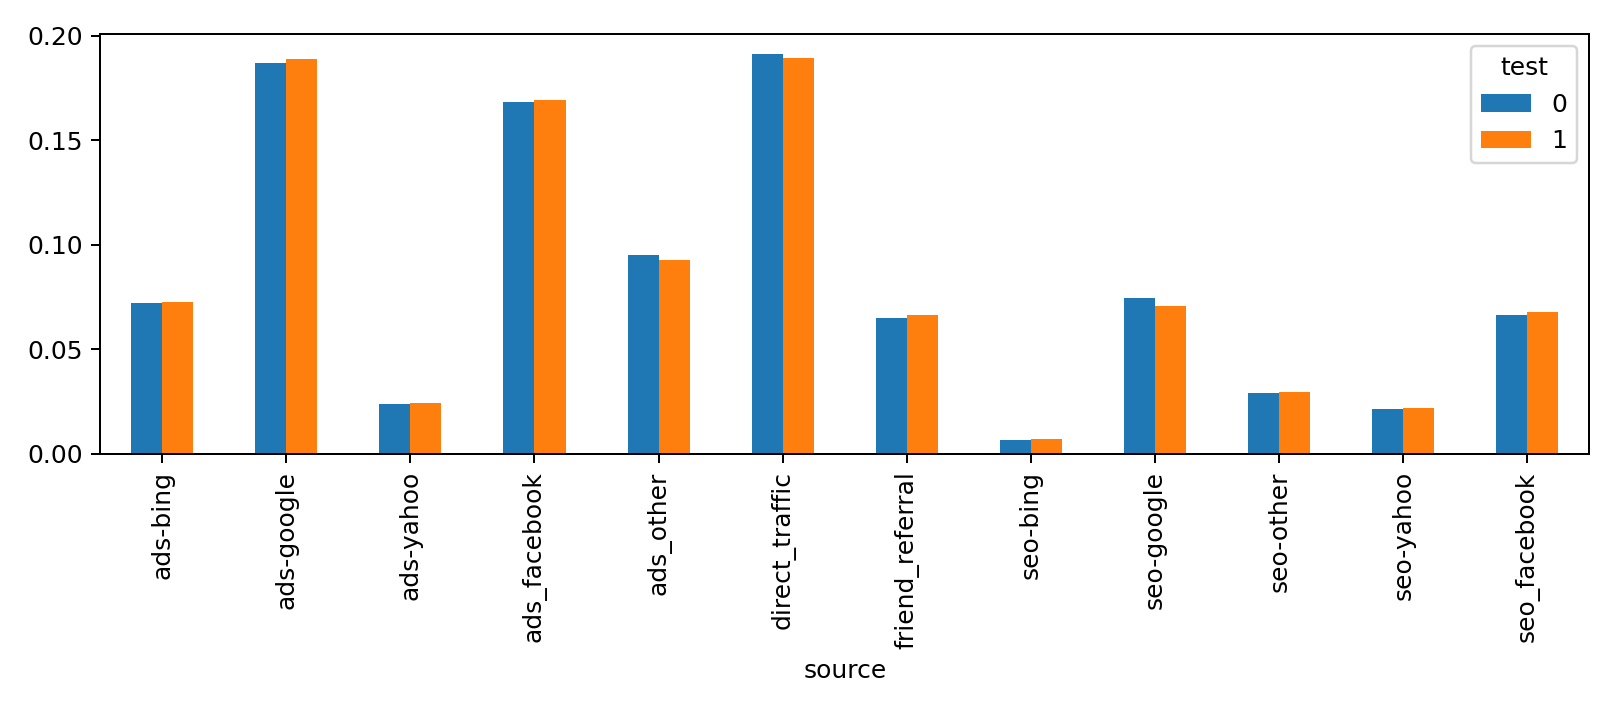

<AxesSubplot:xlabel='source'>

In [10]:
%matplotlib notebook
# 0. Comparison of the source composition between the test and control groups:
merged.groupby("test").apply(lambda x: x.groupby("source")["user_id"].count()/x.shape[0]).T.plot.bar()

<IPython.core.display.Javascript object>


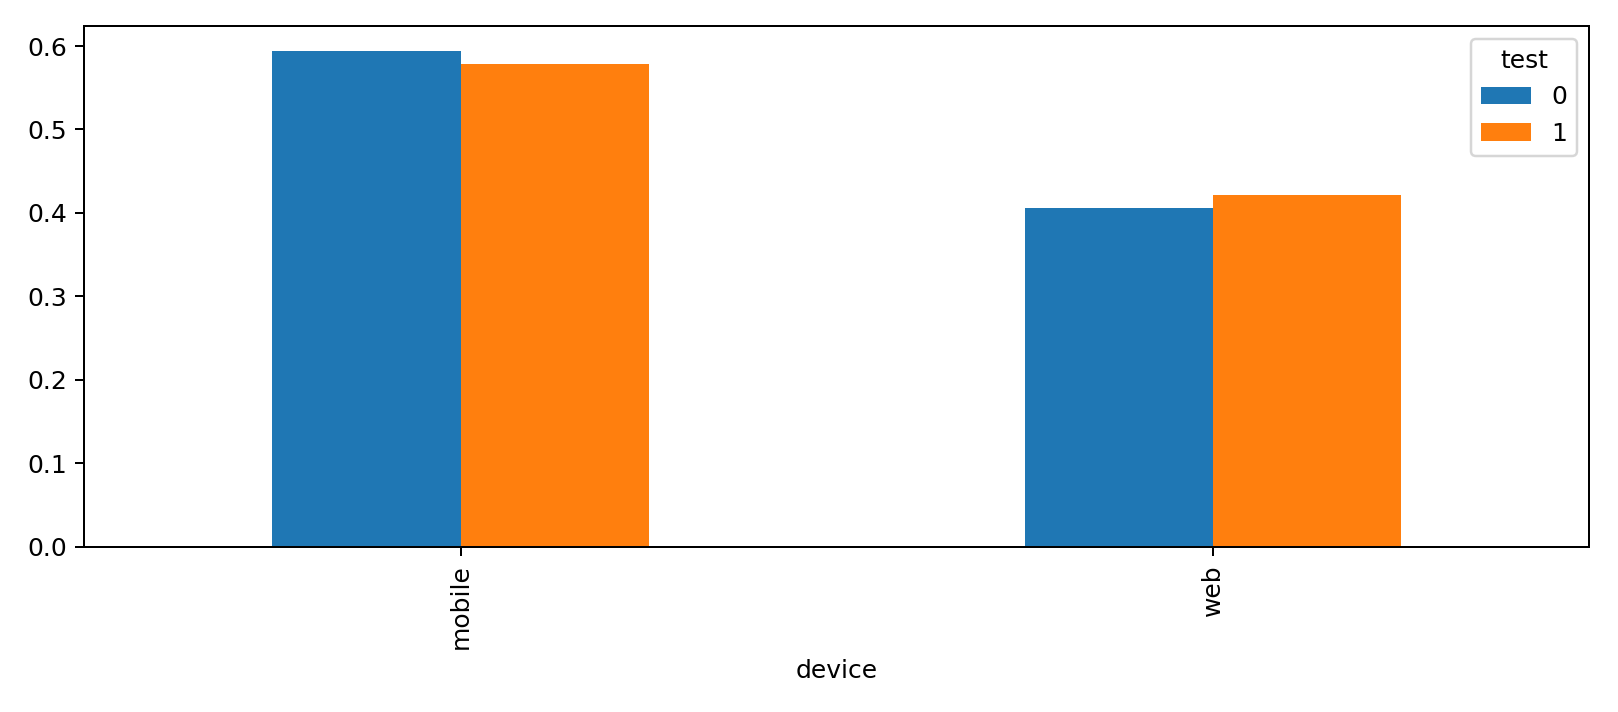

<AxesSubplot:xlabel='device'>

In [11]:
# 1. Comparison of the device composition between the test and control groups:
merged.groupby("test").apply(lambda x: x.groupby("device")["user_id"].count()/x.shape[0]).T.plot.bar()

<IPython.core.display.Javascript object>


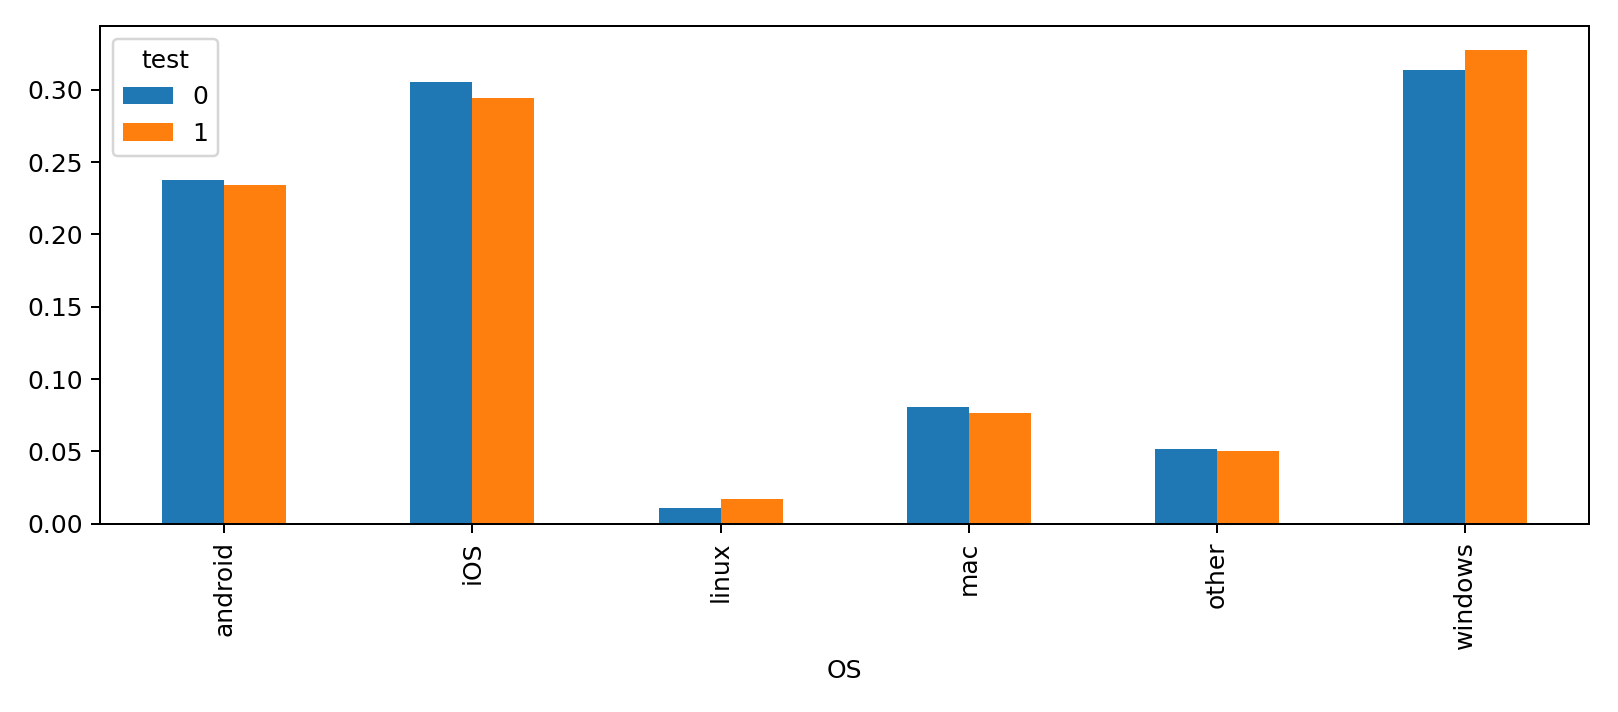

<AxesSubplot:xlabel='OS'>

In [12]:
# 2. Comparison of the operating system composition between the test and control groups:
merged.groupby("test").apply(lambda x: x.groupby("OS")["user_id"].count()/x.shape[0]).T.plot.bar()

In [13]:
def test_of_same_distribution(data, label_col, classes, variables):
    """Test to ensure the same demographic composition of the test and control groups, in
    order to avoid the bias as a result of the confounding between the treatment and the 
    demographic property.
    """
    chi2s, ps, decisions = [], [], []
    for variable in variables:
        sizes1 = data[data[label_col]==classes[1]].groupby(variable).size()
        sizes2 = data[data[label_col]==classes[0]].groupby(variable).size()
        obs = pd.concat([sizes1, sizes2], axis=1).dropna().values

        chi2, p, dof, ex = stats.chi2_contingency(obs)
        chi2s.append(chi2)
        ps.append(p)
        decisions.append("Reject" if p < 0.05 else "Accept")
        
    return pd.DataFrame({"variable":variables, "chi2": chi2s, "p": ps, "H0": decisions})
chi2_test_res = test_of_same_distribution(merged, "test", ["0", "1"], ["source", "device", "OS"])
chi2_test_res

,variable,chi2,p,H0
0,source,30.844873,1.165771e-03,Reject
1,device,75.309731,4.023716e-18,Reject
2,OS,299.441036,1.320793e-62,Reject


The chi-2 test of same distribution shows the test/control groups have different compositions of source / device / OS. This tells us that, even though the source / device / OS compositions between the two groups look similar in the visulizations, there are still significant differences that we should be careful about.  Further power analysis is to be done in Part 3 to see if the sample size used in the chi-2 tests are too large (and thus large power and small p values).

Now, I want to further check if source, device and OS are good explanable variables for predicting conversion and revenue. If the result is yes, then these variables (source, device and OS) will become confounder of the treatment and accordingly cause bias of the A/B Tests.

In [14]:
merged["revenue"] = merged.price * merged.converted.astype(int)
merged[merged.revenue!=0].head(2)

,user_id,timestamp,source,device,OS,test,price,converted,city,country,lat,long,revenue
7,798371,2015-03-15,ads-bing,mobile,android,1,59.0,1,East Orange,USA,40.77,-74.21,59.0
13,460593,2015-03-21,friend_referral,mobile,iOS,0,39.0,1,Hampton,USA,37.05,-76.29,39.0


One random forest classifier of converted~source + device + OS + test will be fitted and one random forest regression of revenue ~ source + device + OS + test will be fitted to investigate if any of source, device or OS can explain the values in converted and the values in revenue.

In [15]:
merged["weight"] = merged.converted.map(lambda x: 53.54645 if x==1 else 1)
merged[["weight", "converted"]].head(10)

,weight,converted
0,1.00000,0
1,1.00000,0
2,1.00000,0
3,1.00000,0
4,1.00000,0
5,1.00000,0
6,1.00000,0
7,53.54645,1
8,1.00000,0
9,1.00000,0


In [16]:
# Investigation of the potential confounders in the A/B test of conversion rate.
modeling_data = merged[["source", "device", "OS", "converted", "revenue", "test", "weight"]]
modeling_data_dummy = pd.get_dummies(modeling_data[["source","device","OS","test","converted"]], drop_first=True)

In [17]:
np.random.seed(1234)
  
trainc, testc = train_test_split(modeling_data_dummy, test_size = 0.34)
rfc = RandomForestClassifier(n_estimators=100, max_features=4, oob_score=True, class_weight={0:1, 1:53.54645})
rfc.fit(trainc.drop('converted', axis=1), trainc['converted'])
  
#OOB accuracy and confusion matrix
print("OOB accuracy is:", rfc.oob_score_, "\nOOB Confusion Matrix:\n", 
pd.DataFrame(confusion_matrix(trainc['converted'], rfc.oob_decision_function_[:,1].round(), labels=[0, 1])))

RandomForestClassifier(class_weight={0: 1, 1: 53.54645}, max_features=4,
                       oob_score=True)

OOB accuracy is: 0.5648701258327873 
OOB Confusion Matrix:
         0      1
0  115800  89418
1    1562   2307


In [18]:
print("Test accuracy is:", rfc.score(testc.drop('converted', axis=1),testc['converted']), 
"\nTest Set Confusion Matrix:\n", 
pd.DataFrame(confusion_matrix(testc['converted'], rfc.predict(testc.drop('converted', axis=1)), labels=[0, 1])))

Test accuracy is: 0.5616035204664247 
Test Set Confusion Matrix:
        0      1
0  59350  46424
1    797   1142


<IPython.core.display.Javascript object>


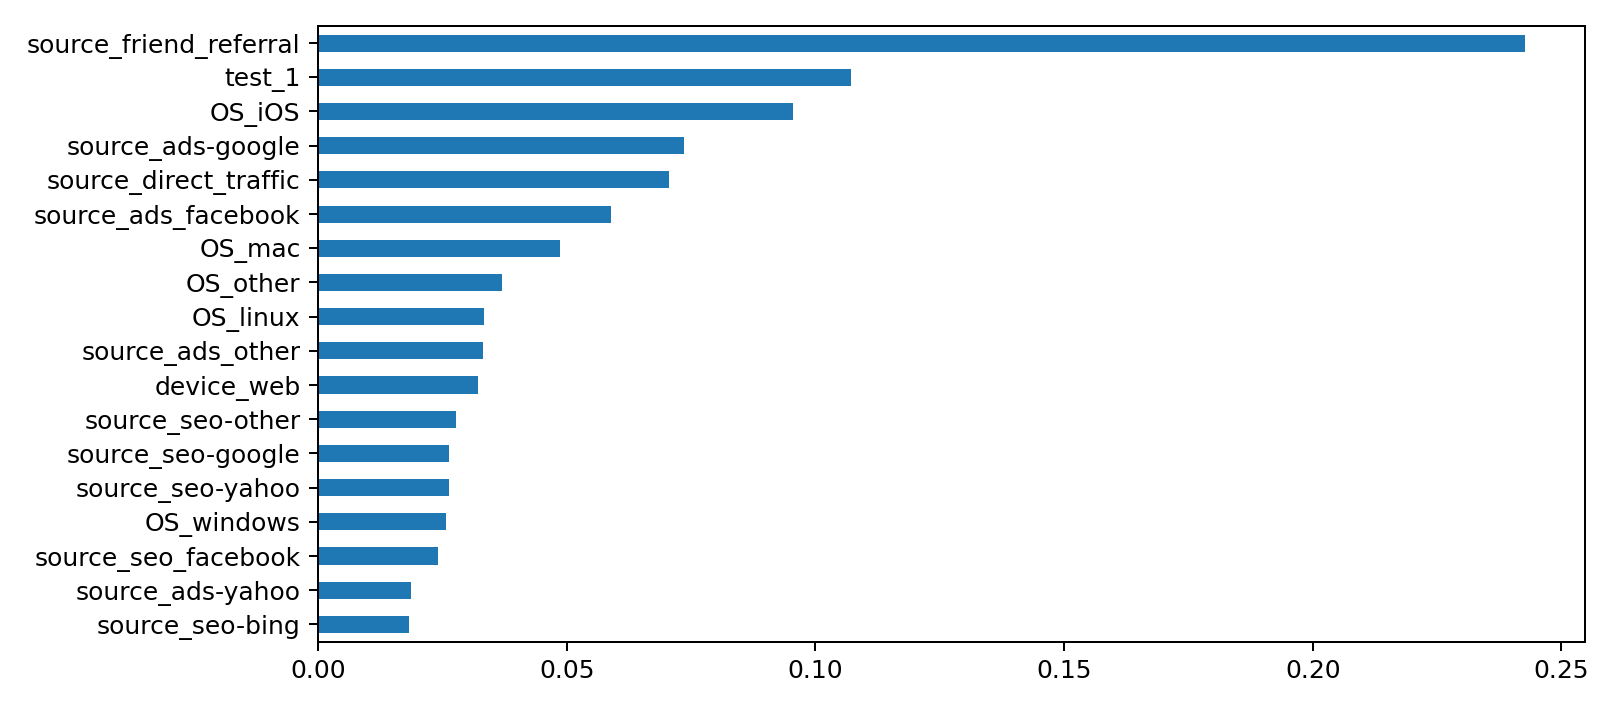

In [25]:
%matplotlib notebook
feat_importances = pd.Series(rfc.feature_importances_, index=trainc.drop('converted', axis=1).columns)
ax = feat_importances.sort_values().plot(kind='barh')

From the feature importance plot, it is not hard to find that: 'source_friend_referral', 'OS_iOS', 'source_ads-google', 'source_direct_traffic', 'source_ads_facebook', 'OS_mac' are good predictors for the values in the column 'converted'. Among of these predictors, 'source_friend_referral' is even more important in predicting the values of 'converted' than the 'test_1' (the treatment factor). Since the composition of 'source' between the test and control groups are different (as found in the chi-2 test), source_friend_referral can be a major confounder in the A/B test of conversion rate. Similarly, the confounding coming from OS may also exist, as a secondary confounder.

In [26]:
# Investigation of the potential confounders in the A/B test of average revenue.
modeling_data_dummy = pd.get_dummies(modeling_data[["source","device","OS","test","revenue","weight"]], drop_first=True)

train, test = train_test_split(modeling_data_dummy, test_size = 0.34)
rfr = RandomForestRegressor(n_estimators=100, max_features=4, oob_score=True)
rfr.fit(train.drop(['revenue','weight'], axis=1), train['revenue'], sample_weight=train['weight'])

RandomForestRegressor(max_features=4, oob_score=True)

<IPython.core.display.Javascript object>


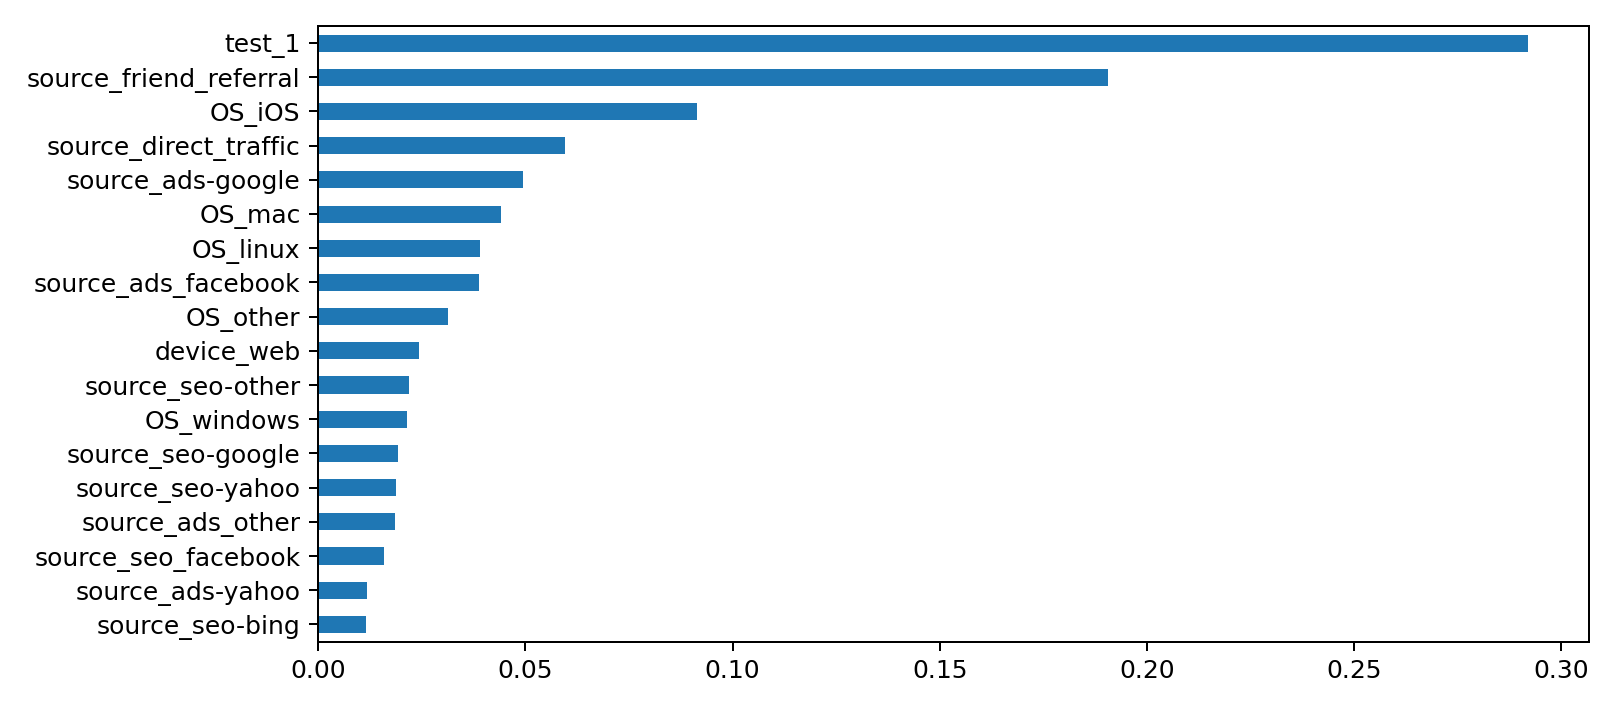

In [27]:
%matplotlib notebook
feat_importances = pd.Series(rfr.feature_importances_, index=train.drop(['revenue','weight'], axis=1).columns)
ax = feat_importances.sort_values().plot(kind='barh')

The above shows, in the A/B test of average revenue, even though 'test_1' (the treatment) is the most important predictor of the variable 'revenue', other predictors such as 'source_friend_referral', 'source_direct_traffic', 'OS_iOS', 'source_ads-google' are also important predictors. These listed predictors can be confounders of 'test_1' in this A/B test even though the confounding problem here is less severe than that in the A/B test of conversion rate.

To sum up, since the values in variables source and OS may influence the values of conversion and revenue, we have two potential categorical confounders that will cause bias of the A/B Test about the average revenue. 

Further power analysis is required to confirm if there's real difference in distributions of source and OS between the two groups, and accordingly if there are any confounders. (See Part 3 for the power analysis.)

Below are the tentative results of the A/B Test of conversion and the A/B Test of revenue. The test results will be revisited in Part 3.

In [28]:
# 1. the A/B Test of conversion: two-sample z test of proportions
test_group =  merged[merged.test=="1"]
ctrl_group = merged[merged.test=="0"]
count = [test_group.converted.astype(int).sum(), ctrl_group.converted.astype(int).sum()]
nobs = [test_group.shape[0], ctrl_group.shape[0]]

statsmodels.stats.proportion.proportions_ztest(count, nobs)

(-8.782770948335264, 1.5949576477472644e-18)

If the treatment assignments are fully randomized (and thus the user compositions are completely the same between the test and control groups), conversion rate is significantly decreased after increasing the price from $39 to $59.

In [29]:
# 2. the A/B Test of revenue: two-sample t test of means
stats.ttest_ind(test_group.revenue, ctrl_group.revenue, equal_var=False)

Ttest_indResult(statistic=5.657213077474457, pvalue=1.5407498604678382e-08)

If the treatment assignments are fully randomized (and thus the user compositions are completely the same between the test and control groups), the user average of revenue is significantly increased.

#### Part 2. The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data?

In [30]:
chi2_test_res2 = test_of_same_distribution(merged, "converted", [0, 1], ["source", "device", "OS", "price"])
chi2_test_res2

,variable,chi2,p,H0
0,source,756.346452,4.440086e-155,Reject
1,device,1.209568,2.714177e-01,Accept
2,OS,237.432167,2.728122e-49,Reject
3,price,75.438307,3.770043e-18,Reject


The above shows different device doesn't make difference in conversion rate. And we need to explore the details about all other varialbes (source, OS and price) since conversion rate changes when we are in different levels of these variables.

In below I use the partial dependence plots of the random forest classifier fitted in Part 2 to extract actionable insights that may incrase conversion rate.

In [31]:
trainc.head(1)

,converted,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_web,OS_iOS,OS_linux,OS_mac,OS_other,OS_windows,test_1
114836,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


<IPython.core.display.Javascript object>


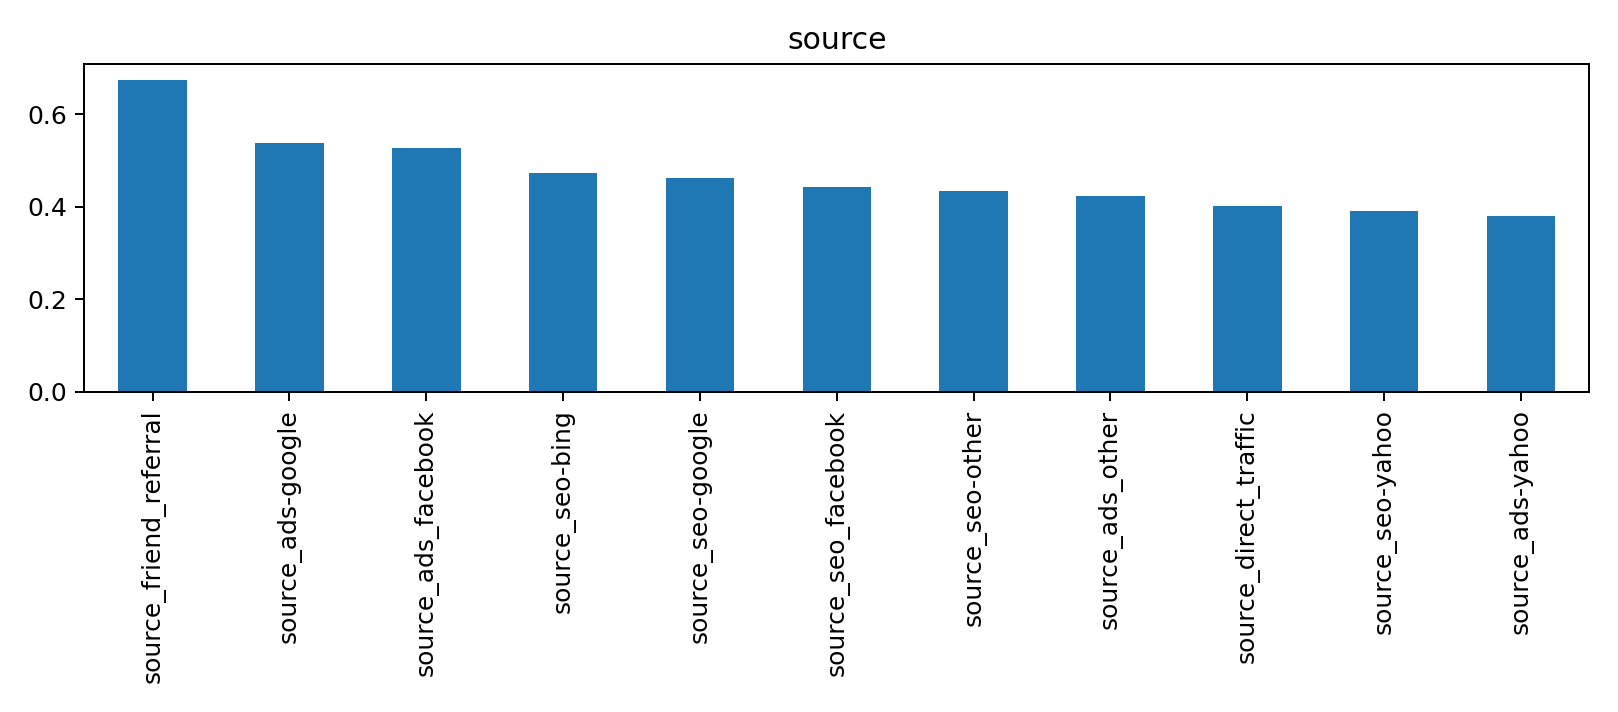

<AxesSubplot:title={'center':'source'}>

In [34]:
%matplotlib notebook
source_cols = [col  for col in train.columns if col.split("_")[0]=="source"]
pdp_iso = pdp.pdp_isolate( model=rfc, 
                          dataset=trainc.drop(['converted'], axis=1),      
                          model_features=list(trainc.drop(['converted'], axis=1)), 
                          feature=source_cols, 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='source')

<IPython.core.display.Javascript object>


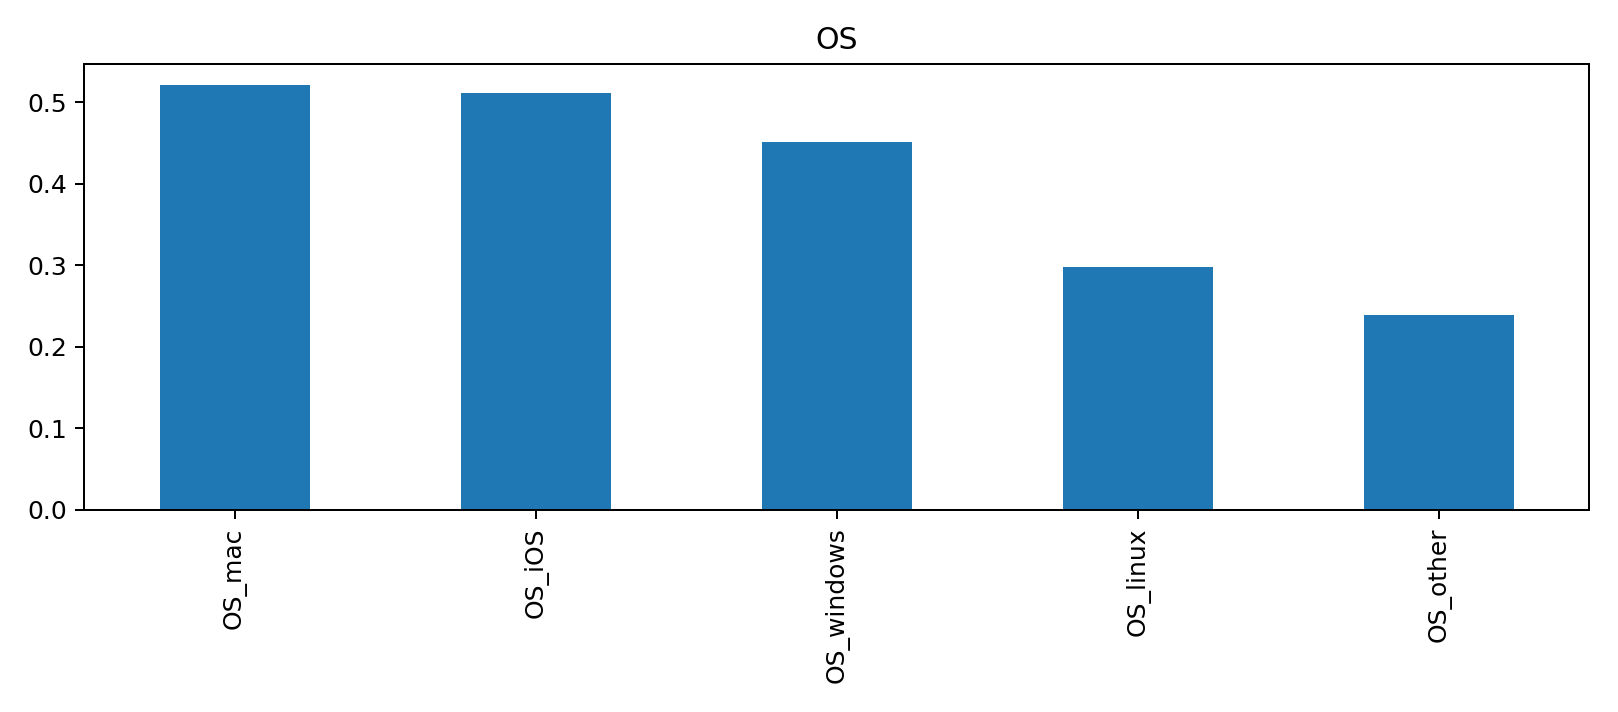

<AxesSubplot:title={'center':'OS'}>

In [37]:
%matplotlib notebook
source_cols = [col  for col in train.columns if col.split("_")[0]=="OS"]
pdp_iso = pdp.pdp_isolate( model=rfc, 
                          dataset=trainc.drop(['converted'], axis=1),      
                          model_features=list(trainc.drop(['converted'], axis=1)), 
                          feature=source_cols, 
                          num_grid_points=50)
pdp_dataset = pd.Series(pdp_iso.pdp, index=pdp_iso.display_columns)
pdp_dataset.sort_values(ascending=False).plot(kind='bar', title='OS')

Actionable insights: 
* From the partial dependence plot of the categorical variable 'source', it is found friend_referral is doing great in increasng the conversion rate, which is followed by the performance of ads_google and ads_facebook. If budget is tight, we should focus on encouraging friend referral, otherwise, we can also invest in running ads on Google and Facebook.
* From the partial dependence plot of the categorical variable 'OS', it is found using iOS and mac (operating system of Apple products) can drive up conversion rate. However, the conversion rate is low when user is using linux operating system. There might be some engineering issue (bug, compatibility, etc) that needs to be fixed.

#### Part 3. The VP of Product feels that the test has been running for too long and they should have been able to get statistically significant results in a shorter time. Do you agree with this? After how many days you would have stopped the test? Please, explain why.

In [38]:
print(merged.groupby("test").apply(lambda x: x.shape[0]))
merged.timestamp.nunique()

test
0    202727
1    114073
dtype: int64


91

The above shows the test have been running for 91 days (3 months)! The control group has 202,727 samples, and the test group has 114,073 samples!

a. power analysis of two-sample t-test of means

In [39]:
merged.groupby("test").apply(lambda x: x.revenue.mean())

test
0    0.776734
1    0.916843
dtype: float64

In [40]:
merged.groupby("test").apply(lambda x: np.var(x.revenue, ddof=1))

test
0    29.718569
1    53.246749
dtype: float64

In [41]:
Xt_bar = 0.916843
Xc_bar = 0.776734
var_t = 53.246749
var_c = 29.718569
alpha = 0.05
power = 0.8
z1 = stats.norm.ppf(1-alpha)
z2 = stats.norm.ppf(power)
d = 0.1 # here the practifically significant difference should be verified by stakeholder with domain knowledge
r = 1/3

In [42]:
n1 = (z1 + z2)**2/d**2 * (var_t/r + var_c/(1-r))
print(int(n1), str(round(n1/316800*100,2))+"%", n1 / (316800/91 ))

126320 39.87% 36.28534085826145


The calculation says we need 39.85% of the data collected and it takes 37 days to collect the data, in order to reach a power of 0.8 with significance level of 0.05.

b. power analysis of two-sample z-test of proportions

In [43]:
merged.groupby("test").apply(lambda x: x.converted.astype(float).mean())

test
0    0.019904
1    0.015543
dtype: float64

In [44]:
p_c = 0.019904
p_c_ = p_c * (1 - p_c)
p_t = 0.015543
p_t_ = p_t * (1 - p_t)
alpha = 0.05
power = 0.8
breakeven_test_convertion_rate = (0.019904 * 39 ) / 59
# if p_c > breakeven_test_convertion_rate is significantly, the price increase will make loss of revenue
d = p_c - breakeven_test_convertion_rate 
z1 = stats.norm.ppf(1-alpha)
z2 = stats.norm.ppf(power)
r = 1/3

In [45]:
n2 = ( z1*np.sqrt( p_c_/(r*(1-r)) ) + z2*np.sqrt( p_t_/r + p_c_/(1-r) ) ) / d**2
print(int(n2), str(round(n2/316800*100,2))+"%", n2 / (316800/91 ))

15773 4.98% 4.531039349971374


The required sample size to achieve a power of 0.8 at significance level of 0.05 is 15,773, which is only 4.98% of the data that we have. This translates to 5 days of data collection. I suggest to collect at least 7 days of data in case of the introduction of weekday-weekend related confounders. 

Conclusion:

1. From above, if the effect sizes of the test of means and proportions are kept as 0.1 and 0.0067, we need to collect 126320 samples in total, which will take about 37 days. 

In [46]:
chi2_test_res = test_of_same_distribution(merged.head(10000), "test", ["0", "1"], ["source", "device", "OS"])
chi2_test_res

,variable,chi2,p,H0
0,source,11.148695,0.430892,Accept
1,device,0.512887,0.473892,Accept
2,OS,25.566830,0.000108,Reject


2. Even we reduce to a very small sample size (10,000 < 15,773 < 126,320), the OS same distribution chi-2 test (between test and control groups) still didn't pass. This means large sample size is not the only cause that make the test_of_same_distribution return "Reject H0", it must be less than ideal (non-randomized) treatment assignment process that created the differences in OS distributions.

In summary, the treatment assignment is not fully randomized and confounders persists such that the test conclusions in Part 1 are not valid. The treatment assignment mechanism should be investigated and corrected (may be there are some engineering issues) and the data should be recollected, after which it become possible to give unbiased test results.